# Sinc DVR dynamics for 3D teweezer potential

In [1]:
# Directives on Jupyter
%reset
# Auto reload bootstrap.py
%load_ext autoreload
%autoreload 2


## Full diagonalization

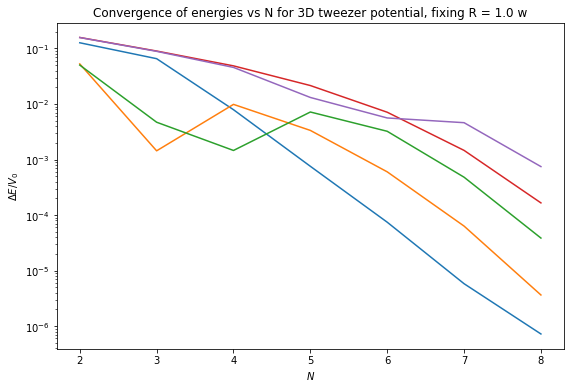

In [4]:
from DVR3d_full import *
import matplotlib.pyplot as plt

Nmax = 8
# WARNING: do not run N >40 on PC
N, dE, E1 = N_convergence(range(1, Nmax + 1), R0)

f = plt.figure(figsize=(20, 6))
ax1 = f.add_subplot(1, 2, 1)
for i in range(k):
    ax1.semilogy(N[1:], abs(dE[:, i]))
ax1.set_xlabel('$N$')
ax1.set_ylabel('$\Delta E/V_0$')
ax1.set_title(
    'Convergence of energies vs N for 3D tweezer potential, fixing R = {} w'.
    format(R0[0] / w))


## TO-DO:

<!-- 1. Calculate ground state of time-average potential $T+V/2$ -->
2. Consider effect of gravity and others

## 2D test

H_mat: model is harmonic potential.
H_mat: model is harmonic potential.
H_mat: model is harmonic potential.


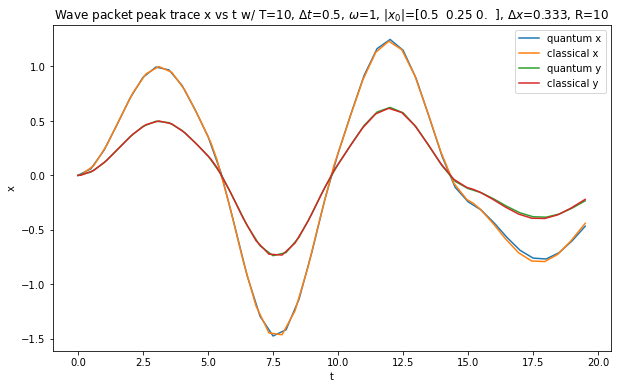

In [3]:
import numpy as np
from dynamics import *
import matplotlib.pyplot as plt
from dynamics_sho_classical import *
from opt_einsum import contract
from einops import rearrange, reduce, repeat

T = 10
t_step = T / 20
n = np.array([30, 30, 0])
dx = 1/3 * np.ones(3, dtype=float)
x0 = np.array([0.5, 0.25, 0])
t_list = np.arange(0 * T, 2 * T, t_step)
x_vs_t = np.array([]).reshape(0, 4)

psi0 = coherent_state(n, dx, np.zeros(3))
peak_pos = np.zeros(3, dtype=float)

def firstfun(x, y, z):
    return shftdVfun(x, y, z, x0)

def lastfun(x, y, z):
    return shftdVfun(x, y, z, -x0)

E1, W1 = H_solver(n, dx, potential=firstfun, model='sho')
E2, W2 = H_solver(n, dx, potential=lastfun, model='sho')
E_lsit = [E1, E2]
W_list = [W1, W2]

def psi(x, psi1):
    xn = [np.arange(-n[i], n[i]+1) * dx[i] for i in range(3)]

    def f(x, xn, dx):
        if xn.size == 1:
            return np.ones((1, 1))
        else:
            return 1/np.sqrt(dx) * np.sinc((np.array([x])[:, None] - xn[None])/dx)

    f3d = contract('ij,kl,mn->ikmjln', f(x[0], xn[0], dx[0]),
                    f(x[1], xn[1], dx[1]), f(x[2], xn[2], dx[2]))
    f3d = rearrange(f3d, 'i k m j l n -> i k m (j l n)')
    psi_x = f3d @ psi1
    return psi_x

psi1 = psi0
for t in t_list:
    def target(x): return -abs(psi(x, psi1))
    peak_pos = fmin(target, peak_pos, disp=False)
    x_vs_t = np.append(x_vs_t, np.insert(
        peak_pos[:], 0, t)[None, :], axis=0)
    psi1 = wavepocket_dynamics(psi1, t, t_step, T, E_lsit, W_list)
sol = ODE_solver(T, t_list, t_step, x0)

f = plt.figure(figsize=(10, 6))
coord = ['x', 'y', 'z']
for i in range(3):
    if n[i] > 0:
        plt.plot(x_vs_t[:, 0], x_vs_t[:, i+1],
                    label='quantum {}'.format(coord[i]))
        plt.plot(sol.t, sol.y[i, :], label='classical {}'.format(coord[i]))
plt.title(
    'Wave packet peak trace x vs t w/ T={:.3g}, $\Delta t$={:.3g}, $\omega$={}, $|x_0|$={}, $\Delta x$={:.3g}, R={:g}'.format(T, t_step, w, x0, dx[0], n[0] * dx[0]))
plt.xlabel('t')
plt.ylabel('x')
plt.legend()

H_mat: model is harmonic potential.
H_mat: model is harmonic potential.
H_mat: model is harmonic potential.
 

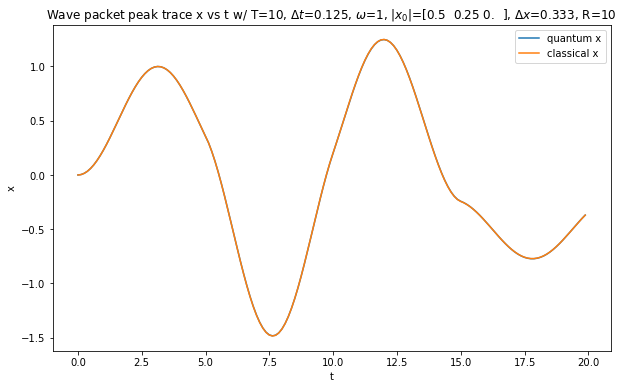

         4136519 function calls (4081489 primitive calls) in 2.676 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     8976    0.202    0.000    1.292    0.000 contract.py:93(contract_path)
     8976    0.124    0.000    0.155    0.000 paths.py:63(ssa_to_linear)
      160    0.117    0.001    2.428    0.015 optimize.py:593(_minimize_neldermead)
53856/8976    0.113    0.000    0.262    0.000 paths.py:190(_optimal_iterate)
88157/78673    0.094    0.000    0.331    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
      320    0.091    0.000    0.094    0.000 dynamics.py:27(int_evo_ops)
    26901    0.087    0.000    0.237    0.000 237774272.py:36(f)
    53856    0.082    0.000    0.143    0.000 paths.py:100(calc_k12_flops)
     8967    0.079    0.000    0.114    0.000 237774272.py:34(<listcomp>)
      160    0.076    0.000    0.170    0.001 dynamics.py:192(coherent_state_dynamics)
     8967    0.0

In [1]:
import numpy as np
from dynamics import *
import matplotlib.pyplot as plt
from dynamics_sho_classical import *
from opt_einsum import contract
from einops import rearrange, reduce, repeat
from scipy.optimize import fmin


def run():
    T = 10
    t_step = T / 80
    n = np.array([30, 0, 0])
    dx = 1/3 * np.ones(3, dtype=float)
    x0 = np.array([0.5, 0.25, 0])
    t_list = np.arange(0 * T, 2 * T, t_step)
    x_vs_t = np.array([]).reshape(0, 4)

    psi0 = coherent_state(n, dx, np.zeros(3))
    peak_pos = np.zeros(3, dtype=float)

    def firstfun(x, y, z):
        return shftdVfun(x, y, z, x0)

    def lastfun(x, y, z):
        return shftdVfun(x, y, z, -x0)

    E1, W1 = H_solver(n, dx, potential=firstfun, model='sho')
    E2, W2 = H_solver(n, dx, potential=lastfun, model='sho')
    E_lsit = [E1, E2]
    W_list = [W1, W2]

    def psi(x, psi1):
        xn = [np.arange(-n[i], n[i]+1) * dx[i] for i in range(3)]

        def f(x, xn, dx):
            if xn.size == 1:
                return np.ones((1, 1))
            else:
                return 1/np.sqrt(dx) * np.sinc((np.array([x])[:, None] - xn[None])/dx)

        f3d = contract('ij,kl,mn->ikmjln', f(x[0], xn[0], dx[0]),
                        f(x[1], xn[1], dx[1]), f(x[2], xn[2], dx[2]))
        f3d = rearrange(f3d, 'i k m j l n -> i k m (j l n)')
        psi_x = f3d @ psi1
        return psi_x

    psi1 = psi0
    for t in t_list:
        def target(x): return -abs(psi(x, psi1))
        peak_pos = fmin(target, peak_pos, disp=False)
        x_vs_t = np.append(x_vs_t, np.insert(
            peak_pos[:], 0, t)[None, :], axis=0)
        psi1 = wavepocket_dynamics(psi1, t, t_step, T, E_lsit, W_list)
    sol = ODE_solver(T, t_list, t_step, x0)

    f = plt.figure(figsize=(10, 6))
    coord = ['x', 'y', 'z']
    for i in range(3):
        if n[i] > 0:
            plt.plot(x_vs_t[:, 0], x_vs_t[:, i+1],
                        label='quantum {}'.format(coord[i]))
            plt.plot(sol.t, sol.y[i, :], label='classical {}'.format(coord[i]))
    plt.title(
        'Wave packet peak trace x vs t w/ T={:.3g}, $\Delta t$={:.3g}, $\omega$={}, $|x_0|$={}, $\Delta x$={:.3g}, R={:g}'.format(T, t_step, w, x0, dx[0], n[0] * dx[0]))
    plt.xlabel('t')
    plt.ylabel('x')
    plt.legend()


%prun run()


In [2]:
import numpy as np
from dynamics_sho import *
import matplotlib.pyplot as plt
from dynamics_sho_classical import *
from opt_einsum import contract
from einops import rearrange, reduce, repeat
from scipy.optimize import fmin


def run():
    # 3D harmonic potential
    print("3D harmonic potential starts.")
    # Rough estimation on memory:
    # grid point = [2n+1 2n+1 2n+1]
    # typical n choice n = 20 or 15, dx = 0.4
    # n = 15, size of matrix ~ 7G
    # n = 20, size of matrix ~ 36G
    # n = 30, size of matrix ~ 380G
    N = 15
    n = np.array([N, N, 0])
    # dx = 1 / 3 * np.ones(3, dtype=float)
    dx = 0.4 * np.ones(3, dtype=float)
    Ndim = np.product(2 * n + 1)
    print("n={}, dx={}, matrix size={:g}".format(n, dx, Ndim))
    mem = 2**(2 * np.log2(Ndim) + 3 - 30)
    print("Estimated matrix memory usage: {:g} GiB".format(mem))
    psi0 = initial_state(n, dx, avg=1/2, potential=Vfun)
    print('Initial state preparation finished.')

    E1, W1 = H_solver(n, dx, avg=1, potential=Vfun)
    E2, W2 = H_solver(n, dx, avg=0)
    E_list = [E1, E2]
    W_list = [W1, W2]
    print('Stroboscopic states preparation finished.')

    for freq in [10.**i for i in range(-1, 2)]:  # frequency unit, V0 ~ 104.52kHz
        t1 = 1 / (2 * freq)  # time period of free system, in unit of 1/V0 ~ 1E-5 s
        # time period of stroboscopic potential system, in unit of 1/V0 ~ 1E-5 s
        t2 = 1 / (2 * freq)
        t_step = t1 + t2
        print("freq={:g} starts.".format(freq))

        if t_step < (t1 + t2):
            print("Dynamic time step is too small.")
            exit(1)

        U = one_period_evo(E_list, W_list, t1, t2)
        rho_rt = np.array([1])
        t = np.array([0])
        t_count = 0
        E, W = sla.schur(U)
        psi = W.conj().T @ psi0
        psi1 = psi0.conj().T @ W
        n_period = int(t_step / (t1 + t2))
        print('matrix power p in each time step: {:g}.'.format(n_period))

        while t_count < 5E1:
            psi = dynamics_by_long_time(t_step,
                                        t1 + t2,
                                        E,
                                        W,
                                        psi,
                                        denseoutput=True)
            rho_rt = np.append(rho_rt, psi1 @ psi)
            t_count += t_step
            t = np.append(t, t_count)
            t_vs_rho = np.concatenate((t[:, None], (abs(rho_rt)**2)[:, None]), axis=1)
            np.savetxt('{} {} {:g} sho.csv'.format(n, dx, freq),
                    t_vs_rho,
                    delimiter=',')
            if t_count % (t_step * 1E3) == 0:
                print("freq={:.2g} t={:.3g} finished.".format(freq, t_count))
        print("freq={:.2g} finished.".format(freq))


%prun run()


3D harmonic potential starts.
n=[15 15  0], dx=[0.4 0.4 0.4], matrix size=961
Estimated matrix memory usage: 0.00688077 GiB
Initial state preparation finished.
Stroboscopic states preparation finished.
freq=0.1 starts.
matrix power p in each time step: 1.
freq=0.1 finished.
freq=1 starts.
matrix power p in each time step: 1.
freq=1 finished.
freq=10 starts.
matrix power p in each time step: 1.
freq=10 finished.
 

         405418 function calls (398696 primitive calls) in 14.630 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        3   10.570    3.523   10.576    3.525 decomp_schur.py:17(schur)
      555    1.770    0.003    1.770    0.003 dynamics_sho.py:82(dynamics_by_long_time)
        3    0.592    0.197    0.592    0.197 linalg.py:1336(eigh)
        6    0.589    0.098    0.589    0.098 dynamics_sho.py:27(int_evo_ops)
        3    0.294    0.098    0.883    0.294 dynamics_sho.py:69(one_period_evo)
      555    0.274    0.000    0.510    0.001 npyio.py:1202(savetxt)
     1110    0.068    0.000    0.073    0.000 {built-in method io.open}
     1110    0.047    0.000    0.047    0.000 {method 'close' of '_io.TextIOWrapper' objects}
        1    0.037    0.037   14.631   14.631 1447296840.py:10(run)
7267/4482    0.027    0.000    1.194    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
       18    0.0